In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from pandas import DataFrame

In [2]:
from matplotlib import rcParams
rcParams.update({
    "font.size": 14})

## Load in FEM Validation Data

In [3]:
burgers = scipy.io.loadmat('matlab/burgers.mat')
X_ = torch.from_numpy(burgers['X']).reshape(-1).float()
T_ = torch.from_numpy(burgers['T']).reshape(-1).float()
u_ = torch.from_numpy(burgers['u']).reshape(-1).float()
X_.requires_grad = True
T_.requires_grad = True
xmin = X_.min()
xmax = X_.max()
N_x = X_.shape[0]

In [4]:
X_.shape, T_.shape, u_.shape

(torch.Size([301]), torch.Size([101]), torch.Size([30401]))

In [5]:
u_ = u_.reshape(X_.shape[0], T_.shape[0])

/opt/anaconda3/envs/ml/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


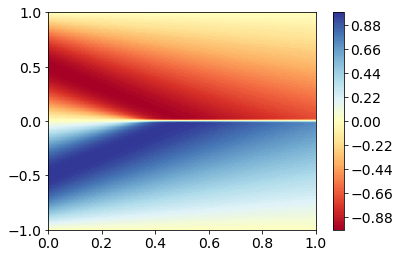

In [6]:
## Evaluate network
x_, t_ = torch.meshgrid(X_, T_)
plt.contourf(t_.detach(), x_.detach(), u_.detach(), levels=100, cmap='RdYlBu')
plt.colorbar()
plt.show()

In [7]:
x_eval = x_.reshape(-1, 1)
t_eval = t_.reshape(-1, 1)

## Defining the function and solution

In [8]:
_u_i = lambda x: -torch.sin(torch.pi*x)
_u_b = lambda t: 0*t

In [9]:
n_x = 20 # Number of data points in interior domain
n_i = 10 # Number of initial points
n_b = 10 # Number of boundary (time) points
n_t = 20
xmin = -1
xmax = 1

# Interior of domain
X = torch.linspace(xmin, xmax, n_x+2, requires_grad=True)[1:-1]
T = torch.linspace(0, 1, n_t+1, requires_grad=True)[1:]
x, t = torch.meshgrid((X, T))
x = x.reshape(-1, 1)
t = t.reshape(-1, 1)

# Initial
x_i = torch.linspace(xmin, xmax, n_i,requires_grad=True).reshape(-1, 1)[1:-1]
t_i = torch.zeros(x_i.shape, requires_grad=True)
u_i = _u_i(x_i)

# Boundary
x_b = torch.cat((xmin*torch.ones(n_b, 1, requires_grad=True),
                 xmax*torch.ones(n_b, 1, requires_grad=True)))
t_b = torch.cat((torch.linspace(0, 1, n_b, requires_grad=True),
                torch.linspace(0, 1, n_b, requires_grad=True)), dim=0).reshape(-1, 1)
u_b = _u_b(t_b)

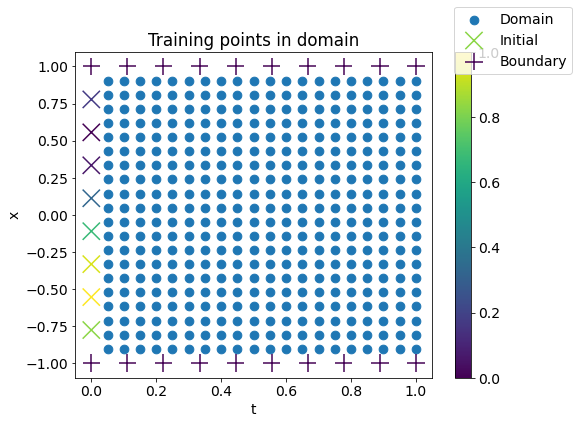

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
d = ax.scatter(t.detach(), x.detach(), marker='.', s=300, label='Domain')
i = ax.scatter(t_i.detach(), x_i.detach(), c=u_i.detach(), marker='x', s=300, label='Initial')
b = ax.scatter(t_b.detach(), x_b.detach(), c=u_b.detach(), marker='+', s=300, label='Boundary')
fig.colorbar(d)
fig.legend()
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Training points in domain')
plt.show()

# Import Network

In [11]:
from BurgersNet import Net

In [12]:
def MSE(net, u_, x, t):
    u = u_.detach().reshape(-1,1)
    u_hat = net(x,t).detach().reshape(-1,1)
    MSE = torch.mean((u - u_hat)**2)
    return MSE

In [13]:
def progress(i, total):
    print("\r", '{:.2f}% '.format((i+1)*100/total), end="")

In [14]:
def number_of_parameters(net):
    return sum([p.numel() for p in net.parameters()])

In [15]:
from model_caching import save_model, load_model, get_model_name

## Hyperparameter Search

In [17]:
N_hid = 30
N_layers = 3
learning_rate = 0.001
act_func = nn.Tanh()
epochs = 5000

In [19]:
lrs = [0.0005, 0.001, 0.005, 0.01]

for lr in lrs:
    print(lr)
    net = Net(N_in=2, N_out=1, N_hid=N_hid, N_layers=N_layers,
        learning_rate=lr, act_func=act_func)

    loss_pde, loss_bc, loss_ic = torch.zeros(epochs), torch.zeros(epochs), torch.zeros(epochs)
    loss_data = torch.zeros(epochs)
    for e in range(epochs):
        loss_pde[e], loss_bc[e], loss_ic[e] = net.step(x, t, x_b, t_b, u_b, x_i, t_i, u_i)
        loss_data[e] = MSE(net, u_, x_eval, t_eval)
        progress(e, epochs)
        if (e+1)%500 == 0:
            print('\nEpoch: {:d}. Data loss: {:.3f}'.format(e+1, loss_data[e]))
    
    model_name = get_model_name(N_hid, N_layers, lr, act_func, epochs)
    save_model(net, loss_data, loss_pde, loss_bc, loss_ic, epochs)

0.0005
 100.00% 0.001
 100.00% 0.005
 100.00% 0.01
 100.00% 

In [26]:
act_funcs = [nn.Tanh(), nn.Sigmoid(), nn.Tanhshrink(), nn.ReLU()]

for act in act_funcs:
    print(str(act)[:-2])
    net = Net(N_in=2, N_out=1, N_hid=N_hid, N_layers=N_layers,
        learning_rate=learning_rate, act_func=act)

    loss_pde, loss_bc, loss_ic = torch.zeros(epochs), torch.zeros(epochs), torch.zeros(epochs)
    loss_data = torch.zeros(epochs)
    for e in range(epochs):
        loss_pde[e], loss_bc[e], loss_ic[e] = net.step(x, t, x_b, t_b, u_b, x_i, t_i, u_i)
        loss_data[e] = MSE(net, u_, x_eval, t_eval)
        progress(e, epochs)
        if (e+1)%500 == 0:
            print('\nEpoch: {:d}. Data loss: {:.3f}'.format(e+1, loss_data[e]))
    
    model_name = get_model_name(N_hid, N_layers, learning_rate, act, epochs)
    save_model(net, loss_data, loss_pde, loss_bc, loss_ic, epochs)

Tanh
 10.00% .08% 
Epoch: 500. Data loss: 0.085
 20.00% 
Epoch: 1000. Data loss: 0.037
 30.00% 
Epoch: 1500. Data loss: 0.034
 40.00% 
Epoch: 2000. Data loss: 0.033
 50.00% 47.42% 
Epoch: 2500. Data loss: 0.032
 60.00% 
Epoch: 3000. Data loss: 0.032
 70.00% 
Epoch: 3500. Data loss: 0.032
 80.00% 
Epoch: 4000. Data loss: 0.032
 90.00% 
Epoch: 4500. Data loss: 0.032
 100.00% 
Epoch: 5000. Data loss: 0.032
Tanh
 10.00% 
Epoch: 500. Data loss: 0.255
 20.00% 
Epoch: 1000. Data loss: 0.101
 30.00% 
Epoch: 1500. Data loss: 0.087
 40.00% 
Epoch: 2000. Data loss: 0.081
 50.00% 
Epoch: 2500. Data loss: 0.068
 60.00% 
Epoch: 3000. Data loss: 0.038
 70.00% 
Epoch: 3500. Data loss: 0.034
 80.00% 
Epoch: 4000. Data loss: 0.033
 90.00% 
Epoch: 4500. Data loss: 0.033
 100.00% 
Epoch: 5000. Data loss: 0.032
Tanh
 10.00% 
Epoch: 500. Data loss: 0.091
 20.00% 
Epoch: 1000. Data loss: 0.079
 30.00% 
Epoch: 1500. Data loss: 0.075
 40.00% 
Epoch: 2000. Data loss: 0.049
 50.00% 
Epoch: 2500. Data loss: 0.035

In [24]:
layers = [1, 2, 3, 4]

for N_l in layers:
    print(N_l)
    net = Net(N_in=2, N_out=1, N_hid=N_hid, N_layers=N_l,
        learning_rate=learning_rate, act_func=act_func)

    loss_pde, loss_bc, loss_ic = torch.zeros(epochs), torch.zeros(epochs), torch.zeros(epochs)
    loss_data = torch.zeros(epochs)
    for e in range(epochs):
        loss_pde[e], loss_bc[e], loss_ic[e] = net.step(x, t, x_b, t_b, u_b, x_i, t_i, u_i)
        loss_data[e] = MSE(net, u_, x_eval, t_eval)
        progress(e, epochs)
        if (e+1)%500 == 0:
            print('\nEpoch: {:d}. Data loss: {:.3f}'.format(e+1, loss_data[e]))
    
    model_name = get_model_name(N_hid, N_l, learning_rate, act_func, epochs)
    save_model(net, loss_data, loss_pde, loss_bc, loss_ic, epochs)

1
 10.00% .70% 
Epoch: 500. Data loss: 0.195
 20.00% 16.80% 
Epoch: 1000. Data loss: 0.118
 30.00% 29.40% 
Epoch: 1500. Data loss: 0.117
 40.00% 39.88% 
Epoch: 2000. Data loss: 0.114
 50.00% 40.96% 
Epoch: 2500. Data loss: 0.110
 60.00% 
Epoch: 3000. Data loss: 0.104
 70.00% 65.42% 
Epoch: 3500. Data loss: 0.099
 80.00% 
Epoch: 4000. Data loss: 0.093
 90.00% 83.28% 
Epoch: 4500. Data loss: 0.089
 100.00% 0.66% 
Epoch: 5000. Data loss: 0.087
2
 10.00% 
Epoch: 500. Data loss: 0.103
 20.00% 
Epoch: 1000. Data loss: 0.090
 30.00% 
Epoch: 1500. Data loss: 0.081
 40.00% 
Epoch: 2000. Data loss: 0.063
 50.00% 
Epoch: 2500. Data loss: 0.031
 60.00% 55.30% 
Epoch: 3000. Data loss: 0.031
 70.00% 
Epoch: 3500. Data loss: 0.030
 80.00% 
Epoch: 4000. Data loss: 0.030
 90.00% 80.32% 
Epoch: 4500. Data loss: 0.030
 100.00% 3.76% 
Epoch: 5000. Data loss: 0.030
3
 10.00% 
Epoch: 500. Data loss: 0.075
 20.00% 
Epoch: 1000. Data loss: 0.032
 30.00% 
Epoch: 1500. Data loss: 0.031
 40.00% 
Epoch: 2000. Dat

In [28]:
N_hids = [10, 30, 50, 100]

for N_h in N_hids:
    print(N_h)
    net = Net(N_in=2, N_out=1, N_hid=N_h, N_layers=N_layers,
        learning_rate=learning_rate, act_func=act_func)

    loss_pde, loss_bc, loss_ic = torch.zeros(epochs), torch.zeros(epochs), torch.zeros(epochs)
    loss_data = torch.zeros(epochs)
    for e in range(epochs):
        loss_pde[e], loss_bc[e], loss_ic[e] = net.step(x, t, x_b, t_b, u_b, x_i, t_i, u_i)
        loss_data[e] = MSE(net, u_, x_eval, t_eval)
        progress(e, epochs)
        if (e+1)%500 == 0:
            print('\nEpoch: {:d}. Data loss: {:.3f}'.format(e+1, loss_data[e]))
    
    model_name = get_model_name(N_h, N_layers, learning_rate, act_func, epochs)
    save_model(net, loss_data, loss_pde, loss_bc, loss_ic, epochs)

10
 10.00% 
Epoch: 500. Data loss: 0.128
 20.00% 
Epoch: 1000. Data loss: 0.105
 30.00% 29.32% 
Epoch: 1500. Data loss: 0.081
 40.00% 
Epoch: 2000. Data loss: 0.036
 50.00% 46.02% 
Epoch: 2500. Data loss: 0.034
 60.00% 
Epoch: 3000. Data loss: 0.033
 70.00% 66.56% 
Epoch: 3500. Data loss: 0.032
 80.00% 
Epoch: 4000. Data loss: 0.032
 90.00% 83.00% 
Epoch: 4500. Data loss: 0.033
 100.00% 
Epoch: 5000. Data loss: 0.032
30
 10.00% 
Epoch: 500. Data loss: 0.078
 20.00% 
Epoch: 1000. Data loss: 0.032
 30.00% 
Epoch: 1500. Data loss: 0.032
 40.00% 
Epoch: 2000. Data loss: 0.032
 50.00% 
Epoch: 2500. Data loss: 0.032
 60.00% 
Epoch: 3000. Data loss: 0.033
 70.00% 
Epoch: 3500. Data loss: 0.033
 80.00% 
Epoch: 4000. Data loss: 0.033
 90.00% 
Epoch: 4500. Data loss: 0.033
 100.00% 
Epoch: 5000. Data loss: 0.033
50
 10.00% 
Epoch: 500. Data loss: 0.071
 20.00% 
Epoch: 1000. Data loss: 0.031
 30.00% 
Epoch: 1500. Data loss: 0.032
 40.00% 33.64% 
Epoch: 2000. Data loss: 0.032
 50.00% 
Epoch: 2500.

## Optimal network

In [29]:
N_hid = 30
N_layers = 3
learning_rate = 0.001
act_func = nn.Tanh()
epochs = 5000

In [30]:
net = Net(N_in=2, N_out=1, N_hid=N_hid, N_layers=N_layers,
    learning_rate=learning_rate, act_func=act_func)
N_params = number_of_parameters(net)

**Training**

In [31]:
loss_pde, loss_bc, loss_ic = torch.zeros(epochs), torch.zeros(epochs), torch.zeros(epochs)
loss_data = torch.zeros(epochs)
for e in range(epochs):
    loss_pde[e], loss_bc[e], loss_ic[e] = net.step(x, t, x_b, t_b, u_b, x_i, t_i, u_i)
    loss_data[e] = MSE(net, u_, x_eval, t_eval)
    progress(e, epochs)
    if (e+1)%500 == 0:
        print('\nEpoch: {:d}. Data loss: {:.3f}'.format(e+1, loss_data[e]))

 10.00% 
Epoch: 500. Data loss: 0.082
 20.00% 
Epoch: 1000. Data loss: 0.032
 30.00% 
Epoch: 1500. Data loss: 0.031
 40.00% 
Epoch: 2000. Data loss: 0.031
 50.00% 
Epoch: 2500. Data loss: 0.031
 60.00% 
Epoch: 3000. Data loss: 0.031
 70.00% 
Epoch: 3500. Data loss: 0.031
 80.00% 
Epoch: 4000. Data loss: 0.031
 90.00% 
Epoch: 4500. Data loss: 0.031
 100.00% 
Epoch: 5000. Data loss: 0.031


**Cash model and results**

Save the NN model to disk (for caching)

In [32]:
# from model_caching import save_model, load_model, get_model_name

# model_name = get_model_name(N_hid, N_layers, learning_rate, act_func, epochs)
# save_model(net, loss_data, loss_pde, loss_bc, loss_ic, epochs)

In [33]:
# net, losses = load_model(N_hid, N_layers, learning_rate, act_func, epochs)

Load the model in from disk (for evaluation)

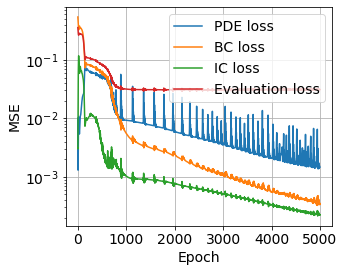

In [34]:
fig, ax = plt.subplots(figsize=(5,4))
ax.semilogy(loss_pde.detach(), label='PDE loss')
ax.semilogy(loss_bc.detach(), label='BC loss')
ax.semilogy(loss_ic.detach(), label='IC loss')
ax.semilogy(loss_data, label='Evaluation loss')
ax.legend()
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
ax.grid()
fig.tight_layout()
# fig.savefig('./figs/hyperparams/Burger_loss_' + model_name + '.png', dpi=600)

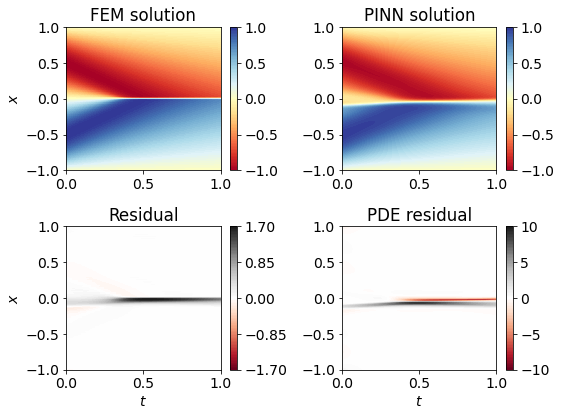

In [35]:
## Evaluate network
fig, axs = plt.subplots(2,2,figsize=(8,6))
axs = axs.flatten()
u_hat = net(x_eval, t_eval).detach().reshape(u_.shape)
pde_hat = net.PDE(x_eval, t_eval).detach().reshape(u_.shape)
vmin = -1 # u_hat.min()
vmax = 1 # u_hat.max()

levels = torch.linspace(vmin, vmax, 100)
c_levels = torch.linspace(vmin, vmax, 5)

m = axs[0].contourf(t_.detach(), x_.detach(), u_.detach(), levels=levels, cmap='RdYlBu')
cb = fig.colorbar(m, ax=axs[0])
cb.set_ticks(c_levels)
axs[0].set_title('FEM solution')
# axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$x$')

m = axs[1].contourf(t_.detach(), x_.detach(), u_hat.detach(), levels=levels, cmap='RdYlBu')
cb = fig.colorbar(m, ax=axs[1])
cb.set_ticks(c_levels)
axs[1].set_title('PINN solution')
# axs[1].set_xlabel('$t$')
# axs[1].set_ylabel('$x$')

vmin = -np.round((u_-u_hat).abs().max(),1)
vmax = -vmin
levels = torch.linspace(vmin, vmax, 100)
c_levels = torch.linspace(vmin, vmax, 5)

m = axs[2].contourf(t_.detach(), x_.detach(), (u_-u_hat).detach(), levels=levels, cmap='RdGy')
cb = fig.colorbar(m, ax=axs[2])
cb.set_ticks(c_levels)
axs[2].set_title('Residual')
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$x$')

vmin = -np.round(pde_hat.abs().max(),0)
vmax = -vmin
levels = torch.linspace(vmin, vmax, 100)
c_levels = torch.linspace(vmin, vmax, 5)
m = axs[3].contourf(t_.detach(), x_.detach(), pde_hat.detach(), levels=levels, vmin=vmin, vmax=vmax, cmap='RdGy')
cb = fig.colorbar(m, ax=axs[3])
cb.set_ticks(c_levels)
axs[3].set_title('PDE residual')
axs[3].set_xlabel('$t$')
# axs[3].set_ylabel('$x$')

fig.tight_layout()
# fig.savefig('./figs/hyperparams/burgers_2D_' + model_name + '.png', dpi=600)


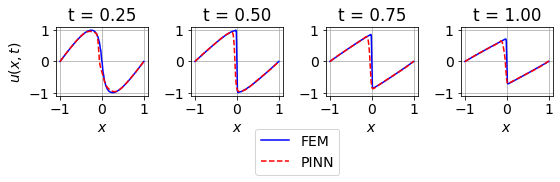

In [36]:
xi, ti = torch.meshgrid(torch.linspace(xmin,xmax,N_x, requires_grad=True), torch.tensor([0.25, 0.5, 0.75, 1]))
#xi, ti = xi.reshape(4, -1), ti.reshape(4, -1)
fig, axs = plt.subplots(1,4,figsize=(8,2.2))
for k, ax in enumerate(axs):
    x = xi[:, k].reshape(-1,1)
    t = ti[:, k].reshape(-1,1)
    u_hat = net(x, t).detach()
    ax.plot(x.detach(), u_[:, (k+1)*25], color='blue', ls='-')
    ax.plot(x.detach(), u_hat, color='red', ls='--')
    ax.set_xlabel('$x$')
    ax.set_title('t = {:.2f}'.format(t[0].item()))
    ax.set_ylim([-1-0.1,1+0.1])
    ax.grid()
axs[0].set_ylabel('$u(x,t)$')
fig.legend(['FEM', 'PINN'], loc="lower center", bbox_to_anchor=(0.53, -0.2))
fig.tight_layout()
# fig.savefig('./figs/hyperparams/burger_eval_1D_' + model_name + '.pdf', bbox_inches='tight')

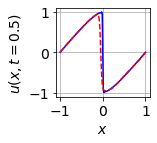

In [37]:
t_eval = 0.5
xi, ti = torch.meshgrid(torch.linspace(xmin,xmax,N_x, requires_grad=True), torch.tensor([t_eval]))
u_hat = net(xi, ti).detach()

f = plt.figure(figsize=(2.4,2.2))
plt.plot(x.detach(), u_[:, T_ == t_eval], color='blue', ls='-')
plt.plot(x.detach(), u_hat, color='red', ls='--')
plt.xlabel('$x$')
plt.ylabel('$u(x,t=0.5)$')
# plt.title('$t = {:.2f}$'.format(t_eval))
plt.ylim([-1-0.1,1+0.1])
plt.grid()
plt.tight_layout()
# f.savefig('./figs/hyperparams/1D_' + model_name + '.pdf', bbox_inches='tight')
plt.show()